In [68]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import lightkurve as lk

from gatspy import  periodic

from tqdm import tqdm

import glob, os

from astropy.table import Table
from astropy.io import fits
import fitsio

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


Populating the interactive namespace from numpy and matplotlib


In [2]:
data = lk.search_lightcurvefile('CR Dra').download()
tpf = lk.search_targetpixelfile('CR Dra').download()

In [3]:
lc = data.PDCSAP_FLUX.remove_nans().normalize()

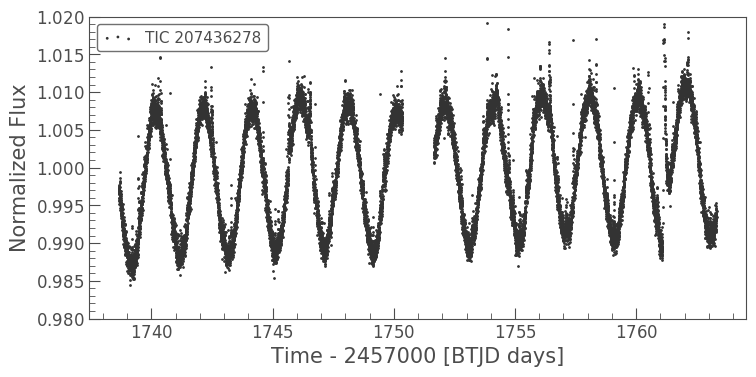

In [4]:
lc.scatter()
plt.ylim(0.98,1.02)
plt.savefig('cr_dra.png')

In [5]:
tpf.interact()

In [6]:
bg = tpf.get_bkg_lightcurve()

(1760, 1762)

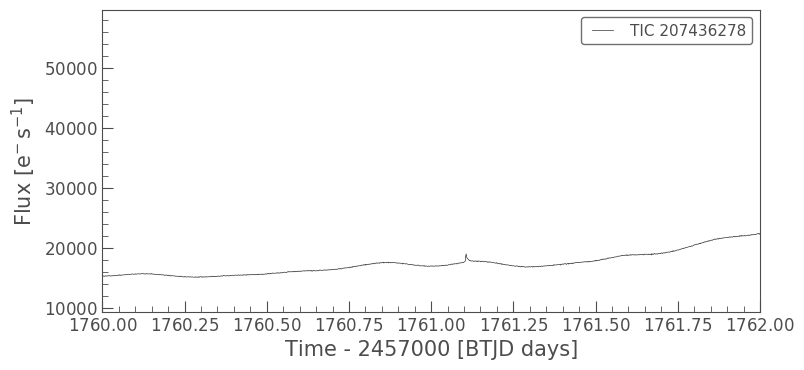

In [7]:
bg.plot()
plt.xlim(1760,1762)

In [8]:
pgram = lc.to_periodogram()

In [9]:
from astropy.timeseries import LombScargle

In [11]:
ls = LombScargle(lc.time,lc.flux,lc.flux_err)

In [12]:
periods = np.linspace(0.5,5,50000)
freqs = 1./periods[::-1]

In [13]:
%%time
power = ls.power(freqs)

CPU times: user 42.5 s, sys: 415 ms, total: 42.9 s
Wall time: 43 s


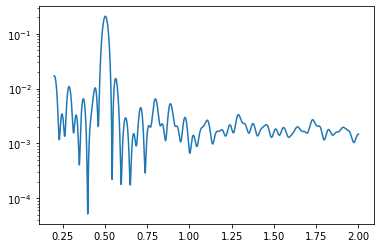

In [14]:
plt.plot(freqs,power)
plt.yscale('log')

In [15]:
1./(freqs[np.argmax(power)])

1.9881797635952723

In [16]:
model = ls.model(lc.time,freqs[np.argmax(power)])

In [17]:
fourier = LombScargle(lc.time,lc.flux,lc.flux_err,nterms=2)

In [18]:
series = fourier.model(lc.time,freqs[np.argmax(power)])

(0.98, 1.02)

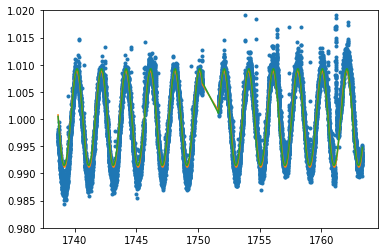

In [19]:

plt.plot(lc.time,lc.flux,'.')
plt.plot(lc.time,model)
plt.plot(lc.time,series)
plt.ylim(0.98,1.02)

(-0.01, 0.01)

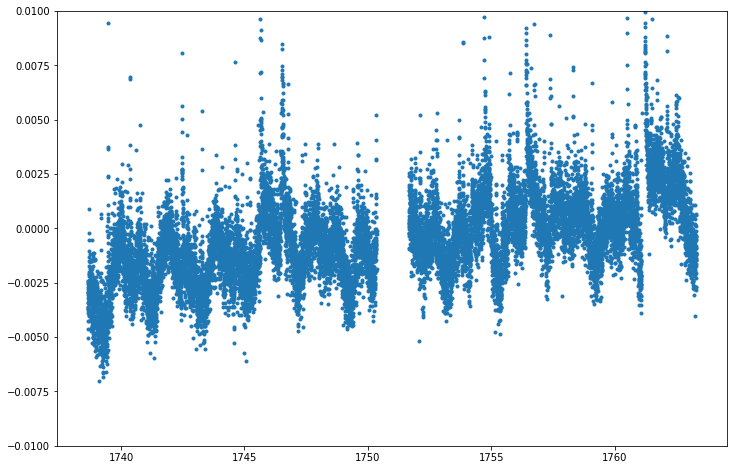

In [20]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(lc.time,lc.flux-series,'.')
plt.ylim(-0.01,0.01)

In [24]:
flat, trend = lc.flatten(return_trend=True)

(0.98, 1.02)

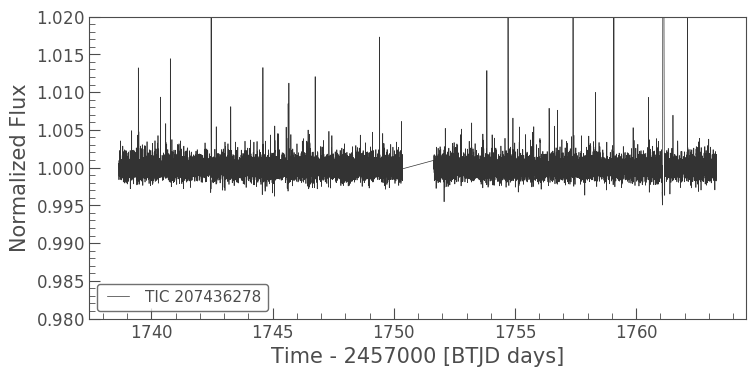

In [25]:
flat.plot()
plt.ylim(0.98,1.02)

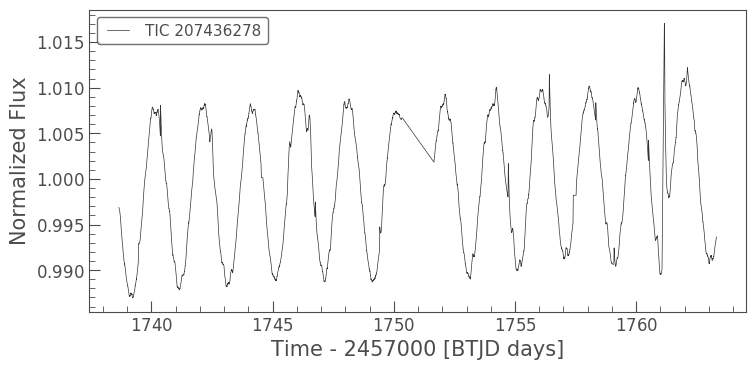

In [26]:
trend.plot()

In [27]:
lc.targetid

207436278

In [28]:
date = lk.utils.btjd_to_astropy_time(lc.time)

In [40]:
start = date.to_datetime()[0]
end = date.to_datetime()[-1]

In [42]:
print(start.date())
print(end.date())

2019-09-12
2019-10-06


In [46]:
lc2 = lc.copy()
lc2.flux = lc.flux - series + np.nanmedian(series)

(0.98, 1.02)

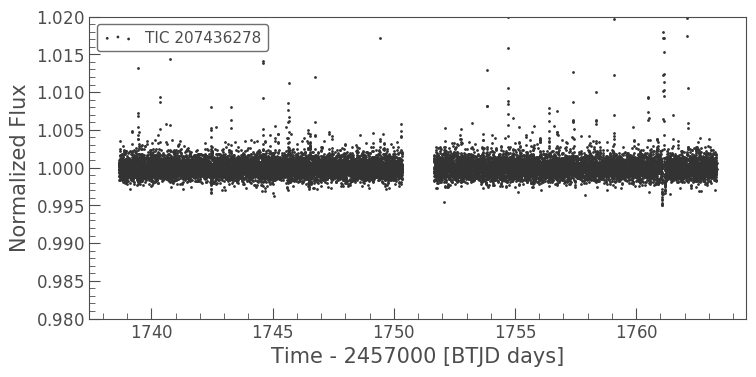

In [52]:
lc2.flatten().scatter()
plt.ylim(0.98,1.02)


In [58]:
cleaned, outliers = lc2.flatten().remove_outliers(return_mask=True)

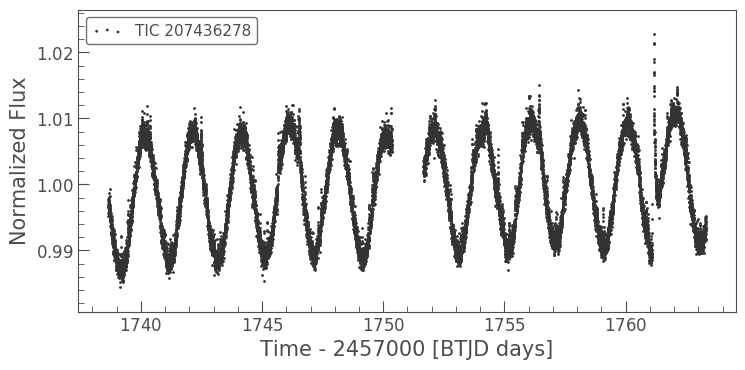

In [61]:
lc[~outliers].scatter()

In [278]:
%%time

tmodel = periodic.TrendedLombScargle(fit_period=True,Nterms=2)
tmodel.quiet = True
tmodel.optimizer.period_range = (1.9, 2.1)

lc_test = lc.copy()
outliers = [0]

for j in tqdm(range(5),desc='Outlier clipping',postfix={'Outliers':np.sum(outliers)}):
    
    tm = tmodel.fit(lc_test.time, lc_test.flux, lc_test.flux_err)
    series = tm.predict(lc_test.time)
    lc2 = lc_test.copy()
    lc2.flux = lc_test.flux - series + np.nanmedian(series)
    cleaned, outliers = lc2.remove_outliers(return_mask=True,sigma=3.0)
    
    lc_test = lc_test[~outliers]
final = tm.predict(lc.time)

Outlier clipping:   0%|          | 0/5 [00:00<?, ?it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  20%|██        | 1/5 [00:01<00:05,  1.31s/it, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  40%|████      | 2/5 [00:02<00:03,  1.28s/it, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  60%|██████    | 3/5 [00:03<00:02,  1.27s/it, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  80%|████████  | 4/5 [00:05<00:01,  1.29s/it, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping: 100%|██████████| 5/5 [00:06<00:00,  1.46s/it, Outliers=0]

CPU times: user 13 s, sys: 1.16 s, total: 14.1 s
Wall time: 6.97 s


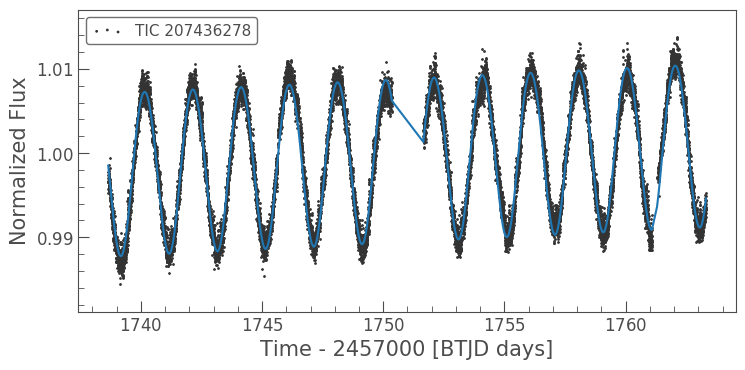

In [264]:
lc_test.scatter()
plt.plot(lc_test.time,series,color=colours[0])

(0.98, 1.02)

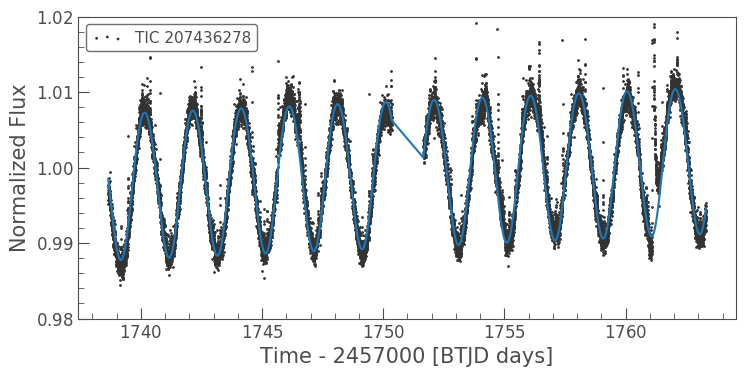

In [282]:
lc.scatter()
plt.plot(lc.time,final,color=colours[0])
plt.ylim(0.98,1.02)

(0.98, 1.02)

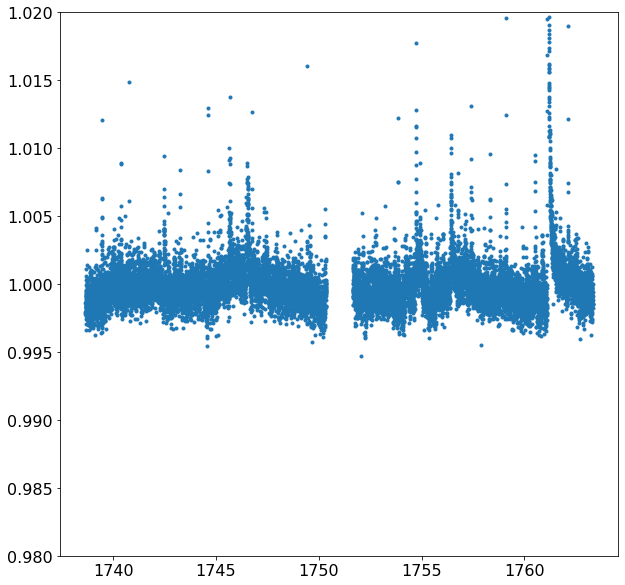

In [283]:
plt.plot(lc.time,lc.flux-final+np.nanmedian(final),'.')
plt.ylim(0.98,1.02)

In [266]:
lk.corrector.Corrector

lightkurve.correctors.corrector.Corrector

In [267]:
cbvs = fitsio.FITS('../data/tess2019253231442-s0016-3-4-0152-s_cbv.fits')

In [268]:
cbvs


  file: ../data/tess2019253231442-s0016-3-4-0152-s_cbv.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       PRIMARY[1]
  1      BINARY_TBL      CBV.single-scale.3.4[1]
  2      BINARY_TBL      CBV.spike.3.4[1]
  3      BINARY_TBL      CBV.multiscale-band-1.3.4[1]
  4      BINARY_TBL      CBV.multiscale-band-2.3.4[1]
  5      BINARY_TBL      CBV.multiscale-band-3.3.4[1]

In [269]:
dummy = []
cadenceno = cbvs[4]['CADENCENO'][:]
for j in range(8):
    dummy.append(cbvs[4]['VECTOR_%d' % (j+1)][:])
cbvs_mat = np.vstack(dummy)

In [270]:
def match_cadences(cbvcads,lccads):
    indices =np.array([1 if j in lccads else 0 for j in cbvcads])
    return np.where(indices==1)[0]


In [271]:
match = match_cadences(cadenceno,lc_test.cadenceno)

In [272]:

regressors = cbvs_mat[:,match].T
dm = lk.DesignMatrix(regressors, name='regressors')


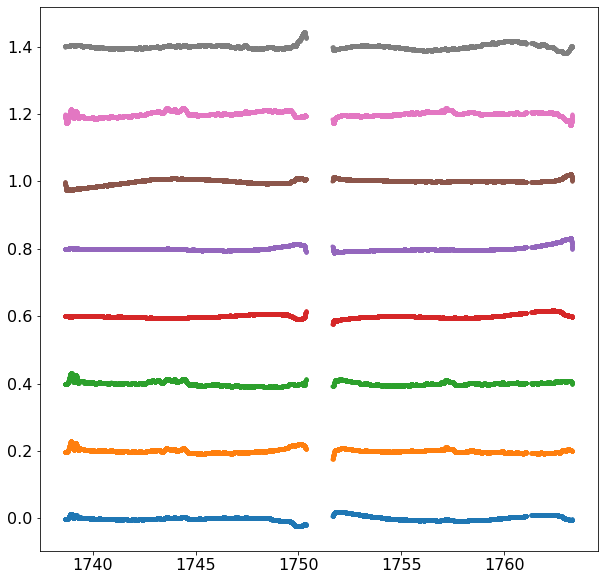

In [273]:
plt.plot(lc_test.time, dm.values + np.arange(8)*0.2, '.');


In [274]:
dm = dm.append_constant()

In [275]:
residuals = lc_test.copy()
residuals.flux = lc_test.flux - series + np.nanmedian(series)
corrector = lk.RegressionCorrector(residuals)

In [276]:
corrected_lc = corrector.correct(dm)


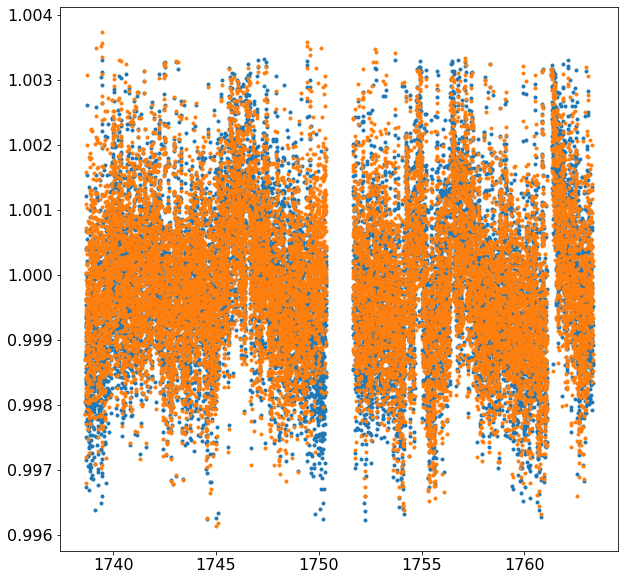

In [277]:
plt.plot(residuals.time,residuals.flux,'.')
plt.plot(corrected_lc.time,corrected_lc.flux,'.')